In [1]:
from google.colab import drive
drive.mount('/content/drive')

IMG_PATH = '/content/drive/MyDrive/Practica_final/COVID-19-CT-Seg_20cases'
MASK_PATH = '/content/drive/MyDrive/Practica_final/Infection_Mask'


Mounted at /content/drive


In [2]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [3]:
def load_nifti(filepath):
    return nib.load(filepath).get_fdata()

def preprocess_slice(img_slice, mask_slice, target_size=(128,128)):
    img_resized = cv2.resize(img_slice, target_size)
    mask_resized = cv2.resize(mask_slice, target_size, interpolation=cv2.INTER_NEAREST)

    # Normalización
    img_resized = (img_resized - np.min(img_resized)) / (np.max(img_resized) - np.min(img_resized) + 1e-7)

    return img_resized, mask_resized


In [4]:
X = []
Y = []

img_files = sorted([f for f in os.listdir(IMG_PATH) if f.endswith('.nii.gz')])

for file in img_files:
    img_file = os.path.join(IMG_PATH, file)
    mask_file = os.path.join(MASK_PATH, file)

    if not os.path.exists(mask_file):
        print(f"Máscara no encontrada para {file}, se omite.")
        continue

    img_vol = load_nifti(img_file)
    mask_vol = load_nifti(mask_file)

    for z in range(img_vol.shape[2]):
        img_slice = img_vol[:,:,z]
        mask_slice = mask_vol[:,:,z]

        if np.sum(mask_slice) > 50:
            img_prep, mask_prep = preprocess_slice(img_slice, mask_slice)
            X.append(img_prep)
            Y.append(mask_prep)

X = np.expand_dims(np.array(X), -1)
Y = np.expand_dims(np.array(Y), -1)
print(f"Slices cargados: {X.shape[0]}")


Slices cargados: 1837


In [5]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")


Train: 1285, Val: 276, Test: 276


In [6]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return 0.2 * bce + 0.8 * dice

def build_unet(input_shape=(128, 128, 1)):
    inputs = tf.keras.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.1)(p1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.1)(p2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(0.2)(p3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Dropout(0.3)(c4)

    # Decoder
    u5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.Concatenate()([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Dropout(0.2)(c5)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Dropout(0.1)(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    return models.Model(inputs, outputs)

# Construir y compilar el modelo
model = build_unet(input_shape=(128, 128, 1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=combined_loss,
              metrics=[dice_coefficient, 'binary_accuracy'])

# Entrenamiento
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=25,
    batch_size=16,
    verbose=1
)


Epoch 1/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 93s 687ms/step - binary_accuracy: 0.6066 - dice_coefficient: 0.0491 - loss: 0.9129 - val_binary_accuracy: 0.9692 - val_dice_coefficient: 0.0328 - val_loss: 0.8863
Epoch 2/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 75s 198ms/step - binary_accuracy: 0.8667 - dice_coefficient: 0.0673 - loss: 0.8708 - val_binary_accuracy: 0.9831 - val_dice_coefficient: 0.0318 - val_loss: 0.8337
Epoch 3/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - binary_accuracy: 0.9477 - dice_coefficient: 0.0787 - loss: 0.8420 - val_binary_accuracy: 0.9830 - val_dice_coefficient: 0.0305 - val_loss: 0.8329
Epoch 4/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - binary_accuracy: 0.9724 - dice_coefficient: 0.0966 - loss: 0.8132 - val_binary_accuracy: 0.9748 - val_dice_coefficient: 0.0285 - val_loss: 0.8302
Epoch 5/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - binary_accuracy: 0.9808 - dice_coefficient: 0.1057 - loss: 0.7955 - val_binary_accuracy: 0.9718 - val_dice_coefficient: 0.0484 - val_loss: 0.

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step
Dice promedio: 0.8301 ± 0.1599
IoU promedio: 0.7322 ± 0.1694


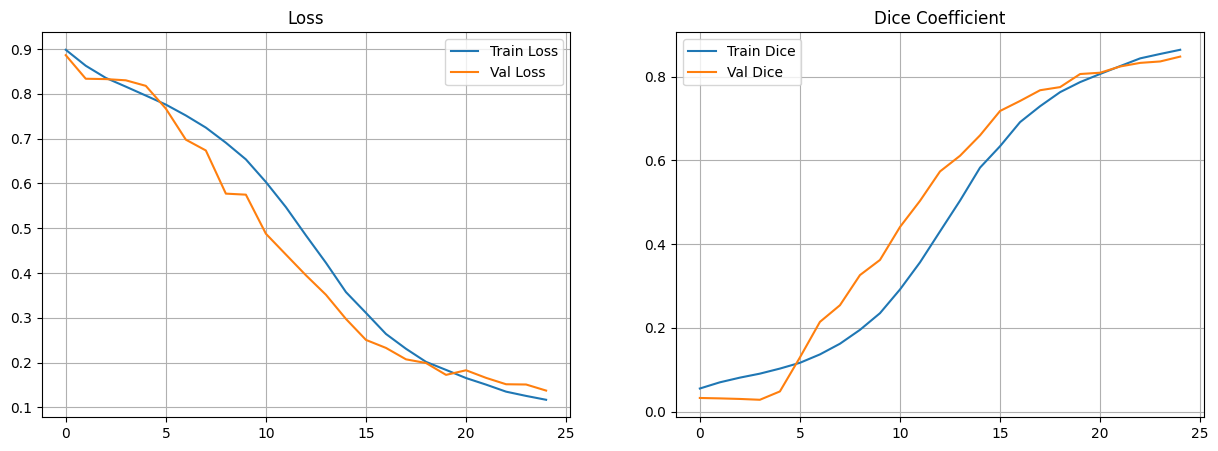

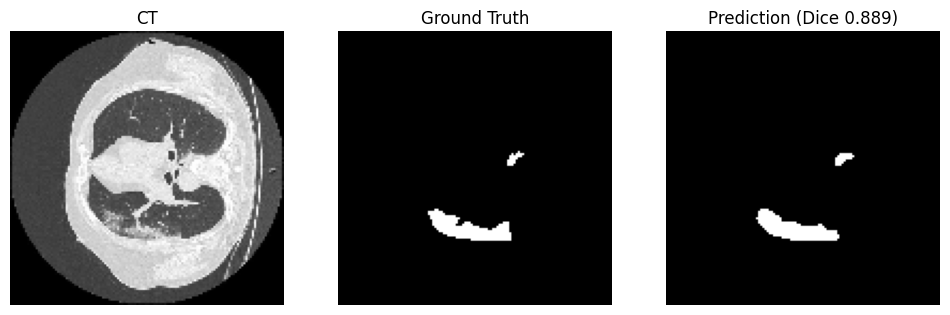

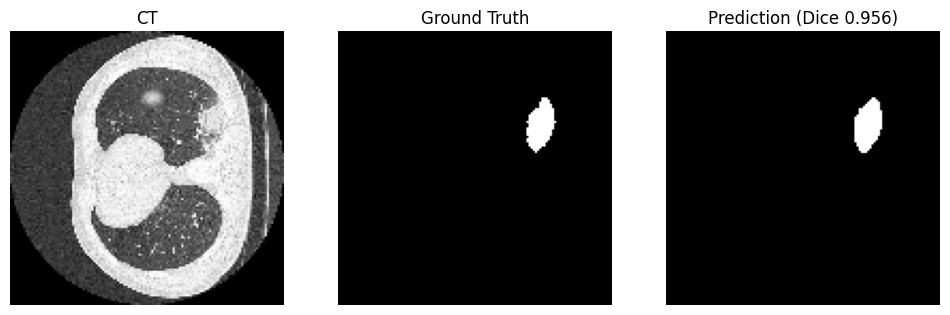

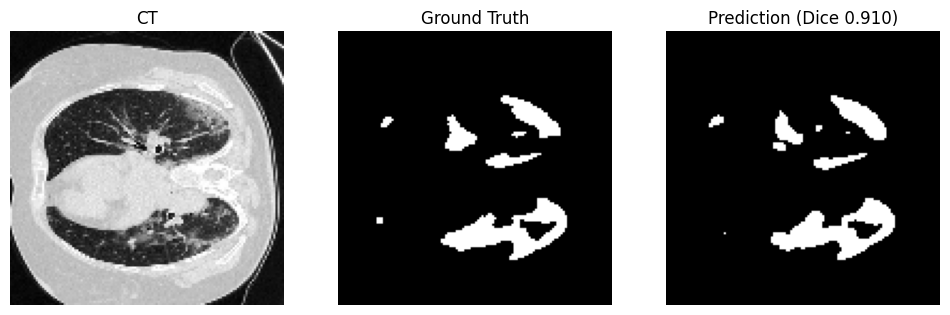

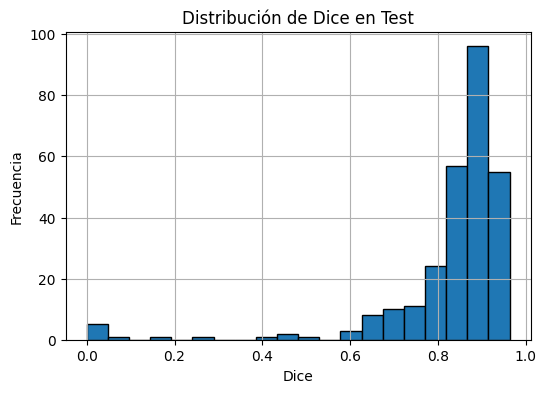

In [7]:
# Predicciones en test
preds = model.predict(X_test, batch_size=16)
preds_bin = (preds > 0.5).astype(np.float32)

# Métricas
def dice_np(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1e-6)

def iou_np(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

dices = [dice_np(Y_test[i], preds_bin[i]) for i in range(len(preds_bin))]
ious = [iou_np(Y_test[i], preds_bin[i]) for i in range(len(preds_bin))]

print(f"Dice promedio: {np.mean(dices):.4f} ± {np.std(dices):.4f}")
print(f"IoU promedio: {np.mean(ious):.4f} ± {np.std(ious):.4f}")

# Curvas de entrenamiento
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['dice_coefficient'], label='Train Dice')
plt.plot(history.history['val_dice_coefficient'], label='Val Dice')
plt.legend()
plt.title('Dice Coefficient')
plt.grid()
plt.show()

# Mostrar algunos ejemplos
for i in range(3):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title('CT')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(Y_test[i].squeeze(), cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(preds_bin[i].squeeze(), cmap='gray')
    plt.title(f'Prediction (Dice {dices[i]:.3f})')
    plt.axis('off')

    plt.show()

# Histograma de Dice
plt.figure(figsize=(6,4))
plt.hist(dices, bins=20, edgecolor='black')
plt.title('Distribución de Dice en Test')
plt.xlabel('Dice')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()
